We'll be using differential dynamic microscopy. This technique was first described in 2008 in an article in PRL by Cerbino and Trappe. 
![PRL image](DDM_Paper_PRL.PNG)
You can find the paper [here](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.188102). 

The heart of the DDM code (found in the `ddm_clean.py` file) is the computation of the image structure function. This is found by taking the average of the Fourier transforms of all image *differences*. By "image differences," I mean the result of subtracting two images separated by a given lag time $\Delta t$.

To describe the process mathematically, we find the difference between images separated by some lag time $\Delta t$:
$$\Delta I = I(x,y;t) - I(x,y;t + \Delta t)$$

For a given $\Delta t$ all such image differences are calculated. We then Fourier transform each $\Delta I$ and average all of the same $\Delta t$.

This results in the image structure function $D(q_x,q_y,\Delta t)$.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 6,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 6,
              }

In [3]:
import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

Y:\Pawan K\DDM\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
Y:\Pawan K\DDM\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
Y:\Pawan K\DDM\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


<IPython.core.display.Javascript object>


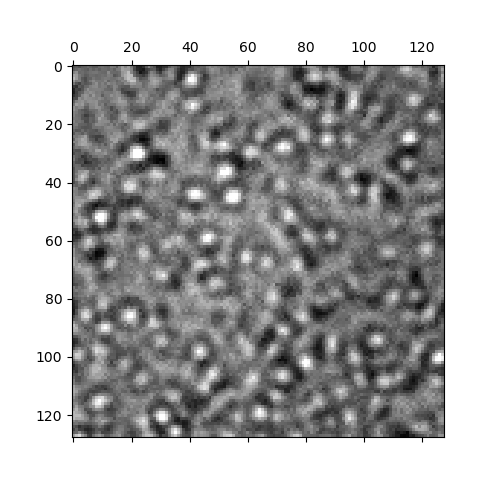

In [57]:
#Specify where the data is stored and the image data filename. Must be in tiff format
data_dir = ".\\ExampleData\\"
data_file = "images_nobin_40x_128x128_8bit.tif"

#Image read using tiff_file module
im = ddm.tiff_file.imread(data_dir+data_file)

#Display the second frame of the image
plt.matshow(im[1], cmap=matplotlib.cm.gray)

------------------------------------------------------
In the cell below, we generate the list of delay times. We will calculate the image structure function for only these set of lag times. 

We are also constructing a filter to multiply the images by. This filter is used to remove artifacts that might appear in the image structure function to the edges of the images. To reduce potential artifacts from the boundaries, we use a Blackman-Harris windowing function. This method was described in the [paper found here](https://arxiv.org/abs/1707.07501). 

In [68]:
numPixels = im.shape[1]
x,y = np.meshgrid(bh(numPixels),bh(numPixels))
filter_func = x*y
#num_pts will be the number of time lags we investigate
num_pts = 30 #usually num_pts was 400 when we have done data analysis
dts = ddm.genLogDist(1,1000,num_pts) 

The cell below will calculate the image structure function. The main function is the `ddm.getFFTDiffsAtTimes`. That function returns the averaged Fourier tranforms of all differences between images separated by the lag times in the list `dts`. 

Those image structure functions are then radially averaged with `ddm.radialAvFFTs_v2`. We can radially average when we know that the dynamics are isotropic. 

The data is then stored in a [dictionary](https://docs.python.org/2/tutorial/datastructures.html?highlight=dictionary#dictionaries) and saved to a file using the [`pickle` function](https://docs.python.org/2/library/pickle.html). 

In [69]:
#With Blackmann-Harris filtering of images:
#fft,dtsB = ddm.getFFTDiffsAtTimes(im[1:,0:numPixels,0:numPixels]*filter_func, dts, every=None, limitImsTo=None, submean=False)

#Without Blackmann-Harris filtering of images:
fft,dtsB = ddm.getFFTDiffsAtTimes(im[1:,0:numPixels,0:numPixels], dts, every=None, limitImsTo=None, submean=False)


ravs = ddm.radialAvFFTs_v2(fft)
dts_fft = {'dts':dts, 'ffts':fft, 'ravs':ravs}
f=open(data_dir + data_file[:-4]+"_1_128x128_FFTDIFFS_dts_ravs.p",'wb')
pickle.dump(dts_fft, f)
f.close()

Running dt=15...



---------------------------------
Since the `getFFTDiffsAtTimes` function can take several minutes (or even hours) to run if the images are large and if we find the image structure function at many lag times, it is best to always save the output to that function. That way, if you want to come back and do more analysis, you just load the saved image structure functions. Loading that saved file is done with the function `pickle.load`.

In [13]:
#open the file with or without BH filtering:
#f = open(data_dir + data_file[:-4]+"_1_BH_128x128_FFTDIFFS_dts_ravs.p",'rb')
f = open(data_dir + data_file[:-4]+"_1_128x128_FFTDIFFS_dts_ravs.p",'rb')
p_data = pickle.load(f)
f.close()
p_data.keys()

dict_keys(['dts', 'ffts', 'ravs'])

In [14]:
#This is how data is stored in dictionaries
ravs = p_data['ravs']
dts = p_data['dts']

In [134]:
np.set_printoptions(threshold=sys.maxsize)
print (p_data['ravs'])


[[  417.5517502    391.50352014   386.10189396   403.19929403
    459.55911285   558.40096834   681.55179063   797.20802017
    927.19048564  1119.57927923  1399.67238076  1825.2052841
   2423.40589337  3163.62052963  3882.34230611  4327.61211057
   4561.71229911  4456.530914    3895.69390864  3124.49104952
   2357.62686859  1677.28305349  1149.72526248   786.20134293
    541.50249349   406.26365321   342.82621897   315.88261928
    285.90851582   260.76132111   247.89908407   243.77442179
    236.20863836   224.92666441   217.52364351   210.82422841
    206.82514203   203.7470125    202.74829287   202.53561522
    200.79327793   200.34155851   199.76374188   199.75315037
    198.25064348   198.13973892   197.84968851   196.97809472
    197.053273     196.78119386   197.45588319   196.7053825
    196.81941973   196.4553638    196.00129366   195.3103076
    195.62463495   195.2617901    195.24329106   195.13378976
    194.24279524   193.97856038   194.42510123   193.84755323]
 [  565.72

<IPython.core.display.Javascript object>


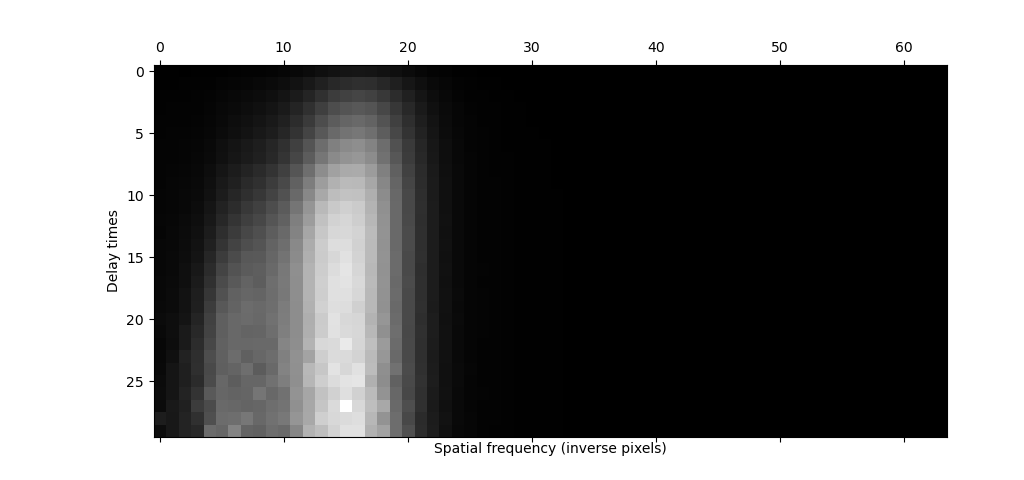

In [15]:
plt.matshow(ravs, cmap=matplotlib.cm.gray)
plt.xlabel("Spatial frequency (inverse pixels)")
plt.ylabel("Delay times");

In [91]:
fps = 41.7 #The frame rate the video data was recorded at
times = dts/fps #Create the list of delay times in units of seconds
pixel_size = 0.242
q = np.arange(0,numPixels/2)*2*np.pi*(1./(numPixels*pixel_size)) #Convert the spatial frequencies to wave vectors

In [92]:
np.arange(0,numPixels/2)*2*np.pi*(1./(numPixels*pixel_size))

array([ 0.        ,  0.20284043,  0.40568087,  0.6085213 ,  0.81136174,
        1.01420217,  1.21704261,  1.41988304,  1.62272348,  1.82556391,
        2.02840435,  2.23124478,  2.43408522,  2.63692565,  2.83976609,
        3.04260652,  3.24544696,  3.44828739,  3.65112783,  3.85396826,
        4.0568087 ,  4.25964913,  4.46248956,  4.66533   ,  4.86817043,
        5.07101087,  5.2738513 ,  5.47669174,  5.67953217,  5.88237261,
        6.08521304,  6.28805348,  6.49089391,  6.69373435,  6.89657478,
        7.09941522,  7.30225565,  7.50509609,  7.70793652,  7.91077696,
        8.11361739,  8.31645783,  8.51929826,  8.72213869,  8.92497913,
        9.12781956,  9.33066   ,  9.53350043,  9.73634087,  9.9391813 ,
       10.14202174, 10.34486217, 10.54770261, 10.75054304, 10.95338348,
       11.15622391, 11.35906435, 11.56190478, 11.76474522, 11.96758565,
       12.17042609, 12.37326652, 12.57610696, 12.77894739])

<IPython.core.display.Javascript object>


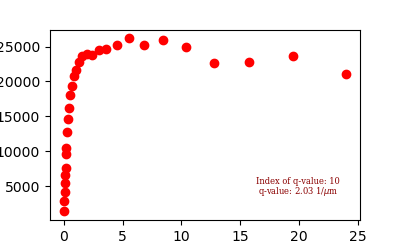

In [77]:
##########################################################################
# Here, we'll show the image structure function for a particular q-value. 
##########################################################################

qv=10
fig = plt.figure(figsize=(4,4./1.618))
plt.plot(times, ravs[:,qv],'ro')
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % qv, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.text(0.8, 0.15, 'q-value: %.2f 1/$\mu$m' % q[qv], horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)', fontdict=font_plt_ax);


--------------------------------------------------------------------------------------
Now we need to fit the image structure functions for each q-value. 

Finding the appropriate fitting function is not always straightforward. When analyzing DDM data, this fitting step is often the most time consuming and potentially frustrating. 

We will try to fit the data using the Levenberg-Marquardt least-squares minimization method implemented in the `mpfit` module. We will also use SciPy's ['leastsq' function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html). 

Both functions seem to do an okay job. One nice feature of the `mpfit` module is that you can specify the minimum and maximum values that each parameter is allowed to take. You can also easily change parameters from ones that are allowed to vary to ones that are fixed. 

One important task when doing the fitting is to come up with good initial guesses. That is what the `ddm.returnReasonableParams` tries to do in an automated fashion. However, you may need to adjust the initial guesses by hand. 

For the Levenberg-Marquardt function, in addition to giving the optimization function the best guess parameters, you give it the minimum values those parameters can take, the maximum values those paramters can take, and a Boolean array specifying whether the parameters are fixed or not. 

<IPython.core.display.Javascript object>


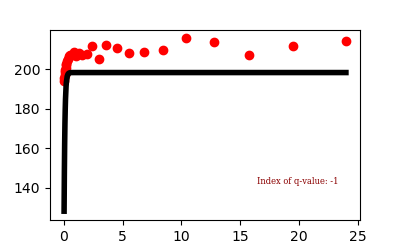

In [21]:
q_index = -1
backg = 100 #change me! <------------------------------------------

#We try to use the function `returnReasonableParams` to find reasonable initial guesses for the fitting function
pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=ravs[:,q_index], bg=backg, double=False, fps=fps)
fig = plt.figure(figsize=(4,4./1.618))
plt.plot(times, ravs[:,q_index],'ro') #plot the data
plt.plot(times, ddm.dTheory(times,*pars), '-k', lw=4) #see how well the initial guess performs
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % q_index, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)');

In [177]:
ravs.shape

(30, 64)

<IPython.core.display.Javascript object>


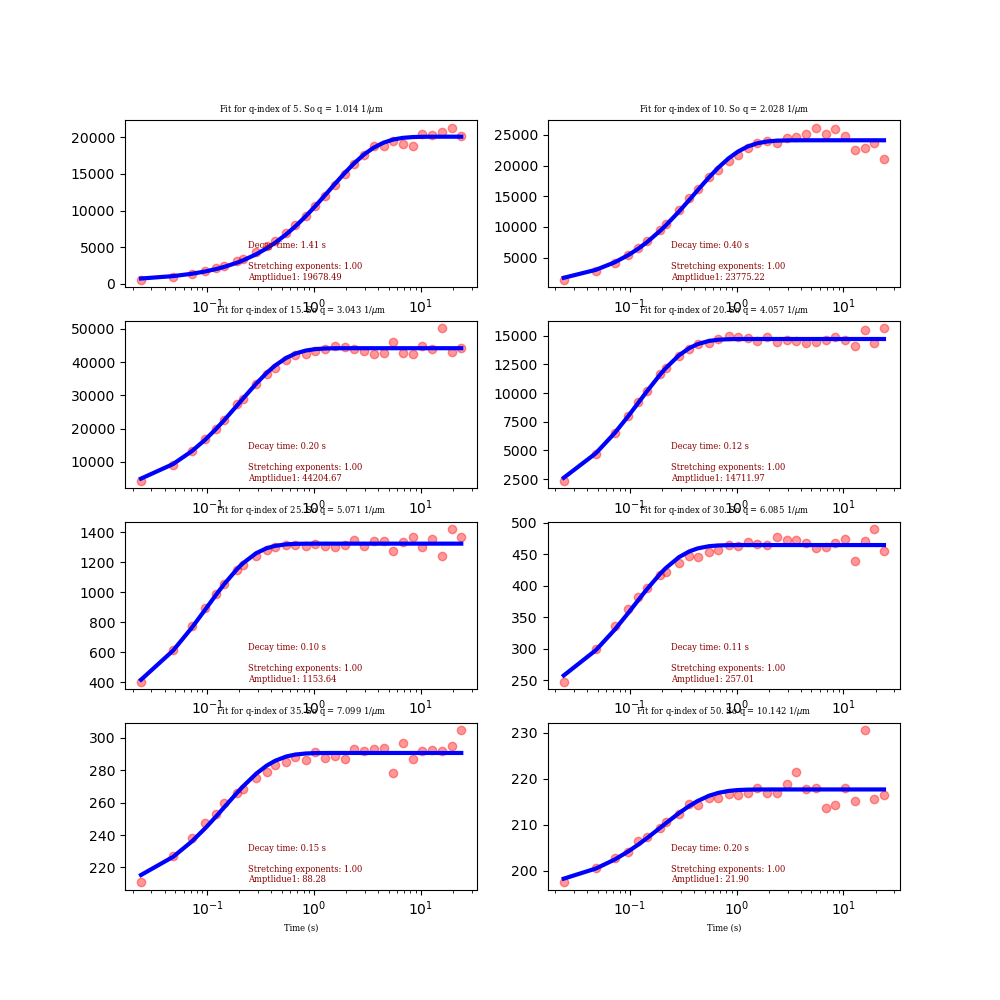

bg: 400.0
bg: 345.28234197400604
bg: 8.000000000000014
bg: 8.0
bg: 170.2373664829723
bg: 207.59612228844907
bg: 202.23247225745763
bg: 195.7792957556208


In [22]:
def two_rounds_fitting(data, times):
    '''
    This function does two rounds of fitting. 
    First it uses SciPy's least-squares fitting:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
    Then, it uses the Levenberg-Marquardt method with the mpfit module. 
    '''

    pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=data, bg=backg, double=False, fps=fps)
    #Paramters:
    # Amplitude-0, TimeConst-1, Background-2, Alpha (strtching exp) - 3, (... same for second exp..))
    
    #Decay time
    # The initial guess for this parameter will be generated automatically
    # But here we can set the minimum and maximum of the possible values. 
    maxp[1] = 1000    #The decay time can't be larger than this
    minp[1] = 0.001   #The decay time can't be smaller than this
    
    #Background
    maxp[2]=400
    minp[2]=8
    pars[2]=backg #This was set in the previous code block
    
    #Stretching exponent. Ideally, this should be 1.0 (which would be a normal exponential)
    minp[3]=0.65   #Can't be smaller than this
    maxp[3]=1.01  #Can't be larger than this
    pars[3]=1.0  #The initial guess. Usually, this should be 1 unless you suspect anomalous behavior. 
    
    #We can choose to allow certain paramters to vary or we can fix them.
    # In the 'fix' vector, if we set to True, the value will be fixed and not allowed to vary.
    fix[3]= True  #Determines whether we fix alpha (the stretching exponent) or not
    fix[2]= False   #Determines whether we fix the background or not.
    
    #The following is for setting parameters for the 2nd exponential. 
    #  But usually we do not use double exponential fits.
    fix[6]= False #6 is the stretching exponent for 2nd exponential
    pars[6] = 0.6
    minp[6] = 0.5 #min alpha2\n",
    maxp[6] = 0.75   #max alpha2\n",
    
    pars[5] = 0.1*pars[1] #5 is the time const for 2nd exponential
    maxp[5] = 100
    minp[5] = 0.01
    '''
    #Leave this commented out for single exponential fits
    totamp = pars[0]+pars[4] ##0 and 4 are the amplitudes
    pars[4] = 0.4*totamp
    pars[0] = 0.4*totamp
    '''

    #The ddm.newFitLeastsq function does not check whether the parameters are within the
    #  minimum and maximum bounds. It uses SciPy's optimize.leastsq. 
    fitparams_lsq,theory_lsq = ddm.newFitLeastsq(data,times,pars,minp,maxp,lmin,lmax,fix,logfit=False)
    newPars = fitparams_lsq.copy()
    
    #We'll use the found parameters from SciPy's optimize.leastsq and feed them into the
    #  Levenberg-Marquardt function. Before we do so, we'll check that none of the found
    #  parameters are outside the min/max bounds. 
    for i,p in enumerate(fitparams_lsq):
        if p>maxp[i]:
            newPars[i] = maxp[i]*0.9
        if p<minp[i]:
            if p<0:
                newPars[i]=abs(p)
                if newPars[i]>maxp[i]:
                    newPars[i] = maxp[i]*0.9
                elif newPars[i]<minp[i]:
                    newPars[i] = minp[i]*1.1
            else:
                newPars[i] = minp[i]*1.1
                
    #Now use the Levenberg-Marquardt function. It returns the optimized paramters (fitparamsB), the 
    #  best fit (theoryB), any error codes, and the chi-squared value (the sum of squares of the error)
    fitparamsB, theoryB, errCodeB, chi2B = ddm.newFit(data,times,newPars,minp,maxp,lmin,lmax,fix,
                                                      logfit=False,quiet=True,factor=0.8)
    
    return fitparamsB, theoryB, chi2B

%matplotlib notebook
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)

q_index = 10  # 10 usually works because it tends to fit well for all types of dynamics
end_time = 300  # change this if the data plateaus early, it is where the fitting stops
#Loop over four different q-values to do the fit
for i,q_index in enumerate([5,10,15,20,25,30,35,50]):
    fitparamsB, theoryB, chi2B = two_rounds_fitting(ravs[:end_time,q_index], times[:end_time])
    #print len(theoryB)
    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,ravs[:,q_index],'ro',alpha=0.4)
    ax.plot(times[:len(theoryB)], theoryB, '-b',lw=3)
    ax.text(0.35,0.25,'Decay time: %.2f s' % fitparamsB[1], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.125,'Stretching exponents: %.2f' % (fitparamsB[3]), 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.06,'Amptlidue1: %.2f' % (fitparamsB[0]),
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    print("bg:", fitparamsB[2])

In [23]:
ravs.shape

(30, 64)

In [24]:
ravs[2]

array([  674.5673639 ,   713.44828009,   741.95084804,   816.26695884,
        1037.84449536,  1400.80057775,  1812.94504312,  2219.82905678,
        2654.23181366,  3289.0859694 ,  4166.65563201,  5597.09393903,
        7451.07629288,  9811.76291323, 11955.14264944, 13203.21915551,
       13743.50696502, 13238.53357681, 11346.61225329,  8884.95721467,
        6506.79837842,  4471.23912176,  2911.99757704,  1854.22193859,
        1167.9258108 ,   774.02302938,   601.3980154 ,   521.71139539,
         440.73130083,   371.54682687,   336.45602127,   325.76193253,
         305.02659468,   275.27566832,   256.41129871,   238.24495536,
         227.45320005,   219.73812602,   216.0411925 ,   214.36290223,
         211.3329598 ,   210.57920706,   208.7814015 ,   207.47918648,
         206.30934731,   205.40135129,   204.78686252,   203.50572066,
         203.29648468,   202.60085902,   202.7036403 ,   201.66790676,
         201.20487726,   200.94711592,   200.14235827,   199.04308101,
      

In [25]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
tau = np.zeros_like(ravs[0,:]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
for i in range(1,len(tau)):
    fitparams, theory, chi2 = two_rounds_fitting(ravs[:,i], times)
    amp[i] = fitparams[0]
    bg[i] = fitparams[2]
    tau[i] = fitparams[1]
    alph[i] = fitparams[3]

In [135]:
np.zeros_like(ravs[0,:])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [148]:
print(amp[:])


[0.00000000e+00 4.36845233e+03 6.53117359e+03 9.41311401e+03
 1.59757334e+04 1.96784905e+04 2.05506376e+04 2.04274962e+04
 1.98724922e+04 2.16515163e+04 2.37752220e+04 2.81624765e+04
 3.45144920e+04 4.01121895e+04 4.31905634e+04 4.42046695e+04
 4.23552947e+04 3.63714826e+04 2.93428016e+04 2.11013667e+04
 1.47119742e+04 9.46338470e+03 5.73285537e+03 3.45623792e+03
 1.98325351e+03 1.15363567e+03 7.88934579e+02 6.23090338e+02
 4.55594084e+02 3.27285802e+02 2.57005929e+02 2.31969007e+02
 1.97325289e+02 1.47238646e+02 1.19376433e+02 8.82751175e+01
 7.07324044e+01 5.85435012e+01 5.10942466e+01 4.61541433e+01
 4.29049558e+01 4.07254928e+01 3.63813555e+01 3.36542952e+01
 3.33629036e+01 2.89645632e+01 2.87741999e+01 2.42531166e+01
 2.41565050e+01 2.50727359e+01 2.19029977e+01 2.11163818e+01
 1.91741843e+01 1.98440642e+01 1.85728088e+01 1.66799265e+01
 1.75644676e+01 1.66515870e+01 1.73959025e+01 1.58542988e+01
 1.55780216e+01 1.58189958e+01 1.40954056e+01 1.64716775e+01]


--------------------
You now will want to inspect the discovered fit parameters. You may need to adjust things (maybe fix certain parameters or allow others, like the background, to vary). 

Often, the parameter we are most interested in is the `tau` parameter -- the decay time. 

For normal diffusive dynamics, we expect that the decay time is inversely proportional to the wave vector squared. The constant of proportionality is 1/D where D is the diffusion coefficient. So we will plot the decay time versus q on a log-log plot. If the dynamics follow normal diffusion, then we should see that the data follows a straight line with a slope of -2. 

<IPython.core.display.Javascript object>


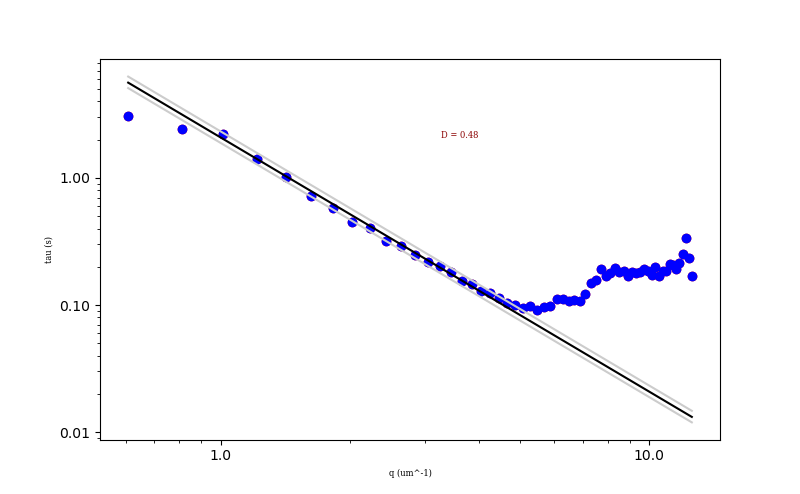

<IPython.core.display.Javascript object>


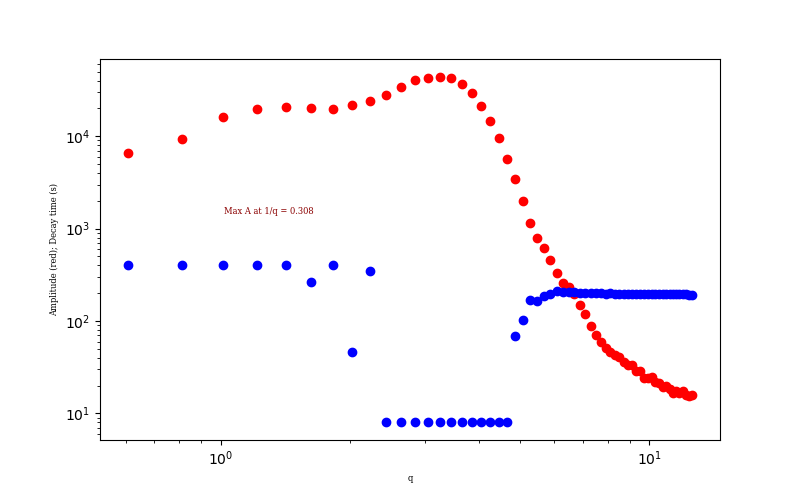

In [175]:
%matplotlib notebook

#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], tau[2:-2], 'ro')
ax.loglog(q[3:-1], ddm.newt(tau[2:-2],alph[2:-2]),'bo')
diffusion_coeff = 0.48
ax.plot(q[3:-1], (1./diffusion_coeff) * 1./(q[3:-1]**2), '-k')
diffusion_coeff_2 = 0.53
ax.plot(q[3:-1], (1./diffusion_coeff_2) * 1./(q[3:-1]**2), '-', c='0.8')
diffusion_coeff_3 = 0.43
ax.plot(q[3:-1], (1./diffusion_coeff_3) * 1./(q[3:-1]**2), '-', c='0.8')
ax.set_xlabel("q (um^-1)", fontdict=font_plt_ax)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.1f}'.format))
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.2f}'.format))
ax.text(0.55,0.8,'D = %.2f' % diffusion_coeff, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)

#Plot the amplitude versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], amp[2:-2], 'ro')
w = amp[2:-1].argmax() #argmax returns the index of the array that has the max value
q_for_max_a = q[3:-1][w]
ax.loglog(q[3:-1], bg[2:-2], 'bo') #Plot the background versus the wave vector
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Amplitude (red); Decay time (s)", fontdict=font_plt_ax)
ax.text(0.2,0.6,'Max A at 1/q = %.3f' % (1.0/q_for_max_a), 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes);


Notice that the decay time versus q follows the expected line fairly well. However, there is some error at the very low and very high q values. At the low-q values, the dynamics are slow (it takes longer for larger scale density fluctuations to decay). Therefore, we might need to take *longer* movies to access those low-q values. But we will likely still see that the data at the very lowest q-values isn't great. At the highest q-values, we see that the background exceeds (by as much as an order of magnitude) the amplitude. Therefore, there is too much noise. One could try to access the higher q-values by recording movies at a faster frame rate (since small spatial scale fluctuations decay quickly) or by imaging with a greater numerical aperture or greater magnification (increasing the resolution). 

Below, we will connect the diffusion coefficient found above (about 0.48 micron^2/s) to the particle radius.

In [1]:
#Fitting with the "good" wave vectors to find the diffusion coefficient

fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], tau[2:-2], 'ro')
ax.loglog(q[3:-1], ddm.newt(tau[2:-2],alph[2:-2]),'bo')



NameError: name 'plt' is not defined

## New method for getting A and B

In [173]:
nframes, ndx, ndy = im.shape
print("Our image has %i frames and each frame is %i x %i pixels" % (nframes, ndx,ndy))

Our image has 3000 frames and each frame is 128 x 128 pixels


In [39]:
#get the average abs(fft)^2 for each frame
av_fftsq_of_each_frame = np.zeros_like(im[0]*1.0)
for i in range(0, nframes):
    fft_of_image = np.fft.fft2(im[i]*1.0)
    sqr_of_fft = np.fft.fftshift(fft_of_image*np.conj(fft_of_image))
    av_fftsq_of_each_frame = av_fftsq_of_each_frame + abs(sqr_of_fft)
av_fftsq_of_each_frame = av_fftsq_of_each_frame/(1.0*nframes*ndx*ndy)

<IPython.core.display.Javascript object>


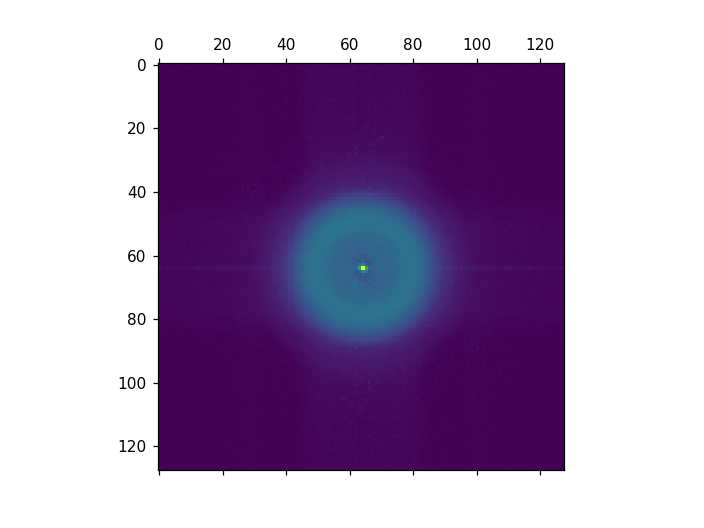

In [40]:
plt.figure()
plt.matshow(np.log(av_fftsq_of_each_frame),fignum=0)

In [42]:
#give the radially averaging function a 3d array because that is what it was written to take
rad_av_av_fftsq = ddm.radialAvFFTs_v2(av_fftsq_of_each_frame.reshape(1,ndx,ndy))

<IPython.core.display.Javascript object>


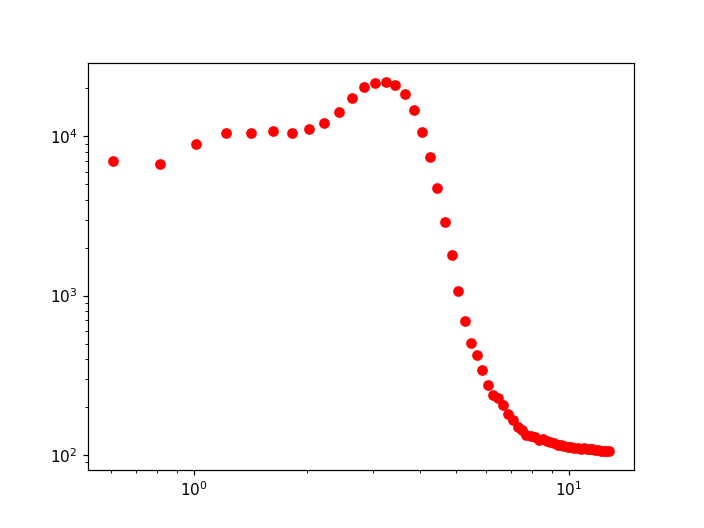

In [44]:
plt.figure()
plt.loglog(q[3:], rad_av_av_fftsq[0,2:-1],'ro')

Based off of the DDM data, let's say the background is ~ 200

In [45]:
new_amplitude = (2*rad_av_av_fftsq[0]) - 200

<IPython.core.display.Javascript object>


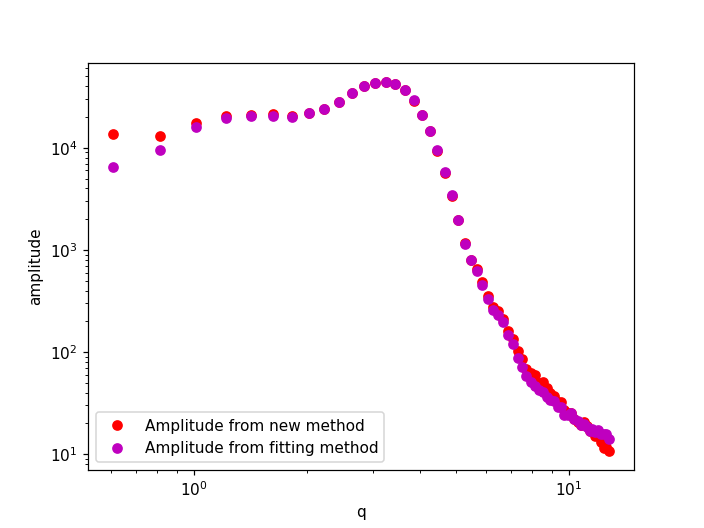

In [46]:
plt.figure()
plt.loglog(q[3:], new_amplitude[2:-1], 'ro', label='Amplitude from new method')
plt.loglog(q[3:], amp[2:-1], 'mo', label='Amplitude from fitting method')
plt.xlabel("q")
plt.ylabel("amplitude")
plt.legend(loc=0)